<a href="https://colab.research.google.com/github/ThomasVanderzande/Coursera_Capstone/blob/main/Capstone_Project_Bubble_Tea_Shop_in_Paris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project - The Battle of Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name='introduction'></a>

In this project we will try to find the best place possible to open a new bubble tea shop in **Paris**, France.

These shops are getting more and more popular in the city so we need to find neighborhoods **with the least amount competition** i.e. tea and coffee shops. As these shops are extremely popular in eastern Asia, we will try to find neighborhoods where people who likes **eastern Asian culture and cuisine** go. 

To go a bit further, we are also interested in places close to **park, shopping points and monuments**, as these drinks tend to be consumed outside whenever possible.

We will find these neighborhoods using data science based on the above-mentioned criteria, to help stakeholders take a decision.



## Data <a name="data"></a>

Factors that will influence our decision are :


*   Whether tea & coffee shops are common or not in the neighborhood
*   The influence of the Asian cuisine in the neighborhood
*   The attractiveness of the neighborhood (park, garden, shopping points, monuments)

The GPS coordinate of neighborhoods can be extracted in Wikipedia via Web Scraping, so we will use them for this project.

The complete list of data needed is the following:

*   GPS coordinates of neighborhoods (**Web Scraping on Wikipedia**)
*   The venues of interest of each neighborhood using **Foursquare API**
*   The coordinate of Paris center will be retrieved using the **geocoder library**

**If you cannot visualize Folium maps please open the notebook in this [link](https://eu-gb.dataplatform.cloud.ibm.com/analytics/notebooks/v2/0b2f9837-503e-4671-8b0d-d6e783537308/view?access_token=6ed0dd881753e27c2fac7d0e13f4c1df31f2395e3e32da4094184a72d736a4df) or click on 'Open in Colab' at the top of the document.**


### Neighborhood Candidates

Let's find GPS coordinates of all neighborhoods in Paris by scraping Wikipedia pages

In [ ]:
!pip install requests
!pip install beautifulsoup4

In [ ]:
import numpy as np
import pandas as pd
import requests
import bs4
import lxml.etree as xml

Let's extract first a list of all neighborhoods in Paris using the above link.

It will also allow us to retrieve the wikipedia page for each neighborhood which contains the GPS coordinates

In [ ]:
URL = "https://fr.wikipedia.org/wiki/Liste_des_quartiers_administratifs_de_Paris"

requests.get(URL)

<Response [200]>

In [ ]:
webPage = bs4.BeautifulSoup(requests.get(URL, {}).text, "lxml")

In [ ]:
table = webPage.find('table')

# We don't need to the header row, so we start from index 1
rows = table.find_all('tr')[1:]

In [ ]:
neighborhoods = []
i = 0

def extract_link_from_a(a):
    waste, part = a.split('href="')
    link, waste = part.split('" ')
    link = "https://fr.wikipedia.org" + link
    return link

for row in rows:
    neighborhood = []
    if i == 4:
      i = 0
    cell_one = row.find_all('td')[2]
    cell_two = row.find_all('td')[1]

    if i == 0:
        link = extract_link_from_a(str(cell_one))
        neighborhood_name = row.find_all('a')[1].text
    else:
        link = extract_link_from_a(str(cell_two))
        neighborhood_name = row.find_all('a')[0].text

    neighborhood.append(neighborhood_name)
    neighborhood.append(link)
    neighborhoods.append(neighborhood)

    i = i + 1

df_paris = pd.DataFrame(neighborhoods, columns=['Neighborhood', 'Wikipedia Link'])
df_paris

,Neighborhood,Wikipedia Link
0,Saint-Germain-l'Auxerrois,https://fr.wikipedia.org/wiki/Quartier_Saint-G...
1,Halles,https://fr.wikipedia.org/wiki/Quartier_des_Halles
2,Palais-Royal,https://fr.wikipedia.org/wiki/Quartier_du_Pala...
3,Place-Vendôme,https://fr.wikipedia.org/wiki/Quartier_de_la_P...
4,Gaillon,https://fr.wikipedia.org/wiki/Quartier_Gaillon
...,...,...
75,Combat,https://fr.wikipedia.org/wiki/Quartier_du_Combat
76,Belleville,https://fr.wikipedia.org/wiki/Quartier_de_Bell...
77,Saint-Fargeau,https://fr.wikipedia.org/wiki/Quartier_Saint-F...
78,Père-Lachaise,https://fr.wikipedia.org/wiki/Quartier_du_P%C3...


Now we have the name of all the neighborhoods with their associated Wikipedia link, we can extract the GPS coordinates of their centroïds. 

As the coordinates are given in hours, minutes, seconds in the Wikipedia page, we will need to create a function that converts the coordinates in decimal values for latitude and longitude.

In [ ]:
def convert_dmo_to_decimal(coordinate):
    coordinates = []
    coordinate = coordinate.replace("\xa0", "").replace("nord","").replace("est","")
    latitude, longitude = coordinate.split(", ")
    for x in [latitude, longitude]:
        hour, remaining = x.split("°")
        minutes, remaining = remaining.split("′")
        seconds, remaining = remaining.split("″")
        x = int(hour) + int(minutes) / 60 + int(seconds) / 3600
        coordinates.append(x)
    return coordinates

coordinates_list = []

for url in df_paris["Wikipedia Link"]:
    neighborhoodPage = bs4.BeautifulSoup(requests.get(url, {}).text, "lxml")
    coordinates = neighborhoodPage.find("span", attrs={"id":"coordinates"})
    coordinates_dmo = coordinates.text
    coordinates_decimal = convert_dmo_to_decimal(coordinates_dmo)
    coordinates_list.append(coordinates_decimal)
  
df_coordinates = pd.DataFrame(coordinates_list, columns=["Latitude", "Longitude"])
df_coordinates

,Latitude,Longitude
0,48.860000,2.340278
1,48.862500,2.344722
2,48.865000,2.337778
3,48.867500,2.329444
4,48.869167,2.332778
...,...,...
75,48.878889,2.380556
76,48.873889,2.385278
77,48.871667,2.404167
78,48.860000,2.396111


Now we have the coordinates of all neighborhoods, let's join both DataFrames to get all the information in one single DataFrame

In [ ]:
df_joined = df_paris.join(df_coordinates)
df_joined

,Neighborhood,Wikipedia Link,Latitude,Longitude
0,Saint-Germain-l'Auxerrois,https://fr.wikipedia.org/wiki/Quartier_Saint-G...,48.860000,2.340278
1,Halles,https://fr.wikipedia.org/wiki/Quartier_des_Halles,48.862500,2.344722
2,Palais-Royal,https://fr.wikipedia.org/wiki/Quartier_du_Pala...,48.865000,2.337778
3,Place-Vendôme,https://fr.wikipedia.org/wiki/Quartier_de_la_P...,48.867500,2.329444
4,Gaillon,https://fr.wikipedia.org/wiki/Quartier_Gaillon,48.869167,2.332778
...,...,...,...,...
75,Combat,https://fr.wikipedia.org/wiki/Quartier_du_Combat,48.878889,2.380556
76,Belleville,https://fr.wikipedia.org/wiki/Quartier_de_Bell...,48.873889,2.385278
77,Saint-Fargeau,https://fr.wikipedia.org/wiki/Quartier_Saint-F...,48.871667,2.404167
78,Père-Lachaise,https://fr.wikipedia.org/wiki/Quartier_du_P%C3...,48.860000,2.396111


Let's visualize the location of each neighborhood in the city of Paris

In [ ]:
!pip install geocoder
!pip install geopy
!pip install folium
import geopy
import geocoder
import folium
from geopy.geocoders import Nominatim

     |████████████████████████████████| 102kB 4.3MB/s 


In [ ]:
address = 'Paris, FR'

geolocator = Nominatim(user_agent="par_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Paris are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Paris are 48.8566969, 2.3514616.


In [ ]:
map_paris = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, neighborhood in zip(df_joined['Latitude'], df_joined['Longitude'], df_joined['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_paris)  

map_paris

**Foursquare API**

Now we have the name and the position of all neighborhoods in Paris, let's find all the venues of interest nearby those neighborhoods using the Foursquare API

In [ ]:
#@title
# Credentials for Foursquare API

CLIENT_ID = '2X502BX4YSBDRQOJEUALDLLZLTUBQ3JV1X3CKDUUVRIE020K' # Foursquare ID
CLIENT_SECRET = 'ZAFQ4SKN3APEPNUWH0JHKVYHSZXZHAMGUFWNJGGUFIJHSREW' # Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 500

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
print('LIMIT:', LIMIT)

Your credentials:
CLIENT_ID: 2X502BX4YSBDRQOJEUALDLLZLTUBQ3JV1X3CKDUUVRIE020K
CLIENT_SECRET:ZAFQ4SKN3APEPNUWH0JHKVYHSZXZHAMGUFWNJGGUFIJHSREW
LIMIT: 500


In [ ]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [ ]:
paris_venues = getNearbyVenues(names=df_joined['Neighborhood'],
                              latitudes=df_joined['Latitude'],
                              longitudes=df_joined['Longitude']
                                  )
paris_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Saint-Germain-l'Auxerrois,48.860000,2.340278,Cour Carrée du Louvre,48.860360,2.338543,Pedestrian Plaza
1,Saint-Germain-l'Auxerrois,48.860000,2.340278,Place du Louvre,48.859841,2.340822,Plaza
2,Saint-Germain-l'Auxerrois,48.860000,2.340278,La Vénus de Milo (Vénus de Milo),48.859943,2.337234,Exhibit
3,Saint-Germain-l'Auxerrois,48.860000,2.340278,Église Saint-Germain-l'Auxerrois (Église Saint...,48.859520,2.341306,Church
4,Saint-Germain-l'Auxerrois,48.860000,2.340278,Pont des Arts,48.858565,2.337635,Bridge
...,...,...,...,...,...,...,...
7872,Charonne,48.852778,2.402222,Domino's Pizza,48.852447,2.403890,Pizza Place
7873,Charonne,48.852778,2.402222,Franprix,48.854550,2.392010,Convenience Store
7874,Charonne,48.852778,2.402222,Extra Old Café,48.848891,2.392708,Brasserie
7875,Charonne,48.852778,2.402222,Café Cosy,48.844859,2.402565,Bar


This concludes the data gathering phase.

We are now ready to analyze the data to find the best neighborhoods to install a new Bubble Tea Shop.

## Methodology

In this project we will try our best to find the neighborhoods with both low hot beverage selling points density (Cafés, Coffee Shops, Tea Room, Bubble Tea Shop) and high attractiveness for people who likes eastern Asian culture.

We now have the required data :

*   GPS coordinates of neighborhoods (Web Scraping on Wikipedia)
*   The venues of interest of each neighborhood using Foursquare API
*   The coordinate of Paris center retrieved using the geocoder library

We will now analyze the data in order to find the most promising neighborhoods for our Bubble Tea future business. We will define **the most common categories of venues of interest** for each neighborhood. We will also **regroup Café, Coffee Shops, Tea Rooms and Bubble Tea Shops** as one category as it will represent the competition for our business.

Finally, to go further into the analysis, we will give additional information about the presence of a **Park, Garden, Shopping Mall, Shopping Plaza or Monument / Landmark** as they tend to make the neighborhood more attractive. This should allow to pick a neighborhood among the most promising ones.

## Analysis

Let's perform some onehot encoding on the venues of interest found during the data collection phase

In [ ]:
# one hot encoding
paris_onehot = pd.get_dummies(paris_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
paris_onehot['Neighborhood'] = paris_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [paris_onehot.columns[-1]] + list(paris_onehot.columns[:-1])
paris_onehot = paris_onehot[fixed_columns]

paris_onehot

,Neighborhood,Accessories Store,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Antique Shop,Aquarium,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auvergne Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Basketball Court,Basque Restaurant,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Breton Restaurant,...,Steakhouse,Street Art,Street Food Gathering,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tech Startup,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,Tram Station,Trattoria/Osteria,Turkish Restaurant,Udon Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Vineyard,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Saint-Germain-l'Auxerrois,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Saint-Germain-l'Auxerrois,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Saint-Germain-l'Auxerrois,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Saint-Germain-l'Auxerrois,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Saint-Germain-l'Auxerrois,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7872,Charonne,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7873,Charonne,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7874,Charonne,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7875,Charonne,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


We regroup the venues of interest for each nieghborhood by calculating the mean value for each Venue Category. The higher the value, the more common a venue category is in a given neighborhood.

In [ ]:
paris_onehot_grouped = paris_onehot.groupby('Neighborhood').mean().reset_index()
paris_onehot_grouped

,Neighborhood,Accessories Store,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Antique Shop,Aquarium,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auvergne Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Basketball Court,Basque Restaurant,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Breton Restaurant,...,Steakhouse,Street Art,Street Food Gathering,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tech Startup,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,Tram Station,Trattoria/Osteria,Turkish Restaurant,Udon Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Vineyard,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Amérique,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.000000,0.011111,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.044444,0.077778,0.0,0.00,0.0,0.011111,0.000000,0.011111,0.00,0.000000,0.022222,0.00,0.00,0.000000,0.0,0.0,0.0,0.000000,0.00,0.00,0.0,...,0.011111,0.0,0.0,0.066667,0.000000,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.000000,0.000000,0.00,0.022222,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.000000,0.00,0.0,0.000000,0.0,0.011111,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.0
1,Archives,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.040000,0.010000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.010000,0.010000,0.0,0.00,0.0,0.000000,0.010000,0.000000,0.01,0.000000,0.020000,0.00,0.05,0.000000,0.0,0.0,0.0,0.000000,0.00,0.01,0.0,...,0.000000,0.0,0.0,0.010000,0.000000,0.0,0.00,0.0,0.00,0.01,0.0,0.02,0.0,0.000000,0.000000,0.00,0.000000,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.000000,0.00,0.0,0.000000,0.0,0.010000,0.0,0.03,0.01,0.0,0.00,0.00,0.00,0.0
2,Arsenal,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.010000,0.010000,0.0,0.010000,0.000000,0.0,0.000000,0.0,0.0,0.010000,0.020000,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.01,0.000000,0.000000,0.01,0.01,0.000000,0.0,0.0,0.0,0.000000,0.00,0.00,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.00,0.0,0.00,0.02,0.0,0.02,0.0,0.000000,0.000000,0.02,0.000000,0.0,0.0,0.0,0.00,0.0,0.01,0.0,0.0,0.0,0.000000,0.00,0.0,0.010000,0.0,0.000000,0.0,0.02,0.01,0.0,0.00,0.00,0.01,0.0
3,Arts-et-Métiers,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.010000,0.010000,0.0,0.010000,0.000000,0.0,0.010000,0.0,0.0,0.060000,0.010000,0.0,0.00,0.0,0.000000,0.030000,0.000000,0.00,0.000000,0.020000,0.00,0.03,0.000000,0.0,0.0,0.0,0.000000,0.00,0.01,0.0,...,0.000000,0.0,0.0,0.010000,0.000000,0.0,0.01,0.0,0.00,0.00,0.0,0.01,0.0,0.000000,0.000000,0.00,0.010000,0.0,0.0,0.0,0.01,0.0,0.00,0.0,0.0,0.0,0.010000,0.00,0.0,0.030000,0.0,0.030000,0.0,0.03,0.01,0.0,0.02,0.00,0.00,0.0
4,Auteuil,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.014925,0.014925,0.0,0.014925,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.00,0.014925,0.000000,0.00,0.00,0.014925,0.0,0.0,0.0,0.014925,0.00,0.00,0.0,...,0.000000,0.0,0.0,0.059701,0.000000,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.238806,0.014925,0.00,0.000000,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.000000,0.00,0.0,0.000000,0.0,0.000000,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,Val-de-Grâce,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.010000,0.010000,0.0,0.020000,0.000000,0.0,0.000000,0.0,0.0,0.020000,0.060000,0.0,0.00,0

To define the venue categories which represent the competition for our business, let's find all venue categories with "Café", "Coffee" and "Tea" in the name.

In [ ]:
# Columns with ["Café", "Coffee", "Tea"] in the name
filtering_conditions = ["Café", "Coffee", "Tea"]

drinkplace_columns = []

for column in paris_onehot_grouped.columns:
    for filtering_condition in filtering_conditions:
       if filtering_condition in column:
          drinkplace_columns.append(column)
          
drinkplace_columns

['Bubble Tea Shop', 'Café', 'Coffee Shop', 'Tea Room']

To define the venue categories which represent the market target for our business, let's find all venue categories with "Asian", "Japanese" and "Chinese" in the name.

In [ ]:
# Columns with ['Asian', 'Chinese', 'Japanese'] in the name
filtering_conditions2 = ['Asian', 'Chinese', 'Japanese']
asian_venues = []

for column in paris_onehot_grouped.columns:
    for filtering_condition2 in filtering_conditions2:
       if filtering_condition2 in column:
          asian_venues.append(column)
          
asian_venues

['Asian Restaurant', 'Chinese Restaurant', 'Japanese Restaurant']

Now we have identified our competition, let's put it in new columns called "Drink Place" and "Asian Venues" which will represent the sum of values of the columns identified above, for each neighborhood.

In [ ]:
paris_onehot_grouped['Drink Place'] = paris_onehot_grouped[drinkplace_columns].sum(axis=1)
paris_onehot_grouped['Asian Venues'] = paris_onehot_grouped[asian_venues].sum(axis=1)
paris_onehot_grouped

,Neighborhood,Accessories Store,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Antique Shop,Aquarium,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auvergne Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Basketball Court,Basque Restaurant,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Breton Restaurant,...,Street Food Gathering,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tech Startup,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,Tram Station,Trattoria/Osteria,Turkish Restaurant,Udon Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Vineyard,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit,Drink Place,Asian Venues
0,Amérique,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.000000,0.011111,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.044444,0.077778,0.0,0.00,0.0,0.011111,0.000000,0.011111,0.00,0.000000,0.022222,0.00,0.00,0.000000,0.0,0.0,0.0,0.000000,0.00,0.00,0.0,...,0.0,0.066667,0.000000,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.000000,0.000000,0.00,0.022222,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.000000,0.00,0.0,0.000000,0.0,0.011111,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.022222,0.055556
1,Archives,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.040000,0.010000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.010000,0.010000,0.0,0.00,0.0,0.000000,0.010000,0.000000,0.01,0.000000,0.020000,0.00,0.05,0.000000,0.0,0.0,0.0,0.000000,0.00,0.01,0.0,...,0.0,0.010000,0.000000,0.0,0.00,0.0,0.00,0.01,0.0,0.02,0.0,0.000000,0.000000,0.00,0.000000,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.000000,0.00,0.0,0.000000,0.0,0.010000,0.0,0.03,0.01,0.0,0.00,0.00,0.00,0.0,0.070000,0.020000
2,Arsenal,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.010000,0.010000,0.0,0.010000,0.000000,0.0,0.000000,0.0,0.0,0.010000,0.020000,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.01,0.000000,0.000000,0.01,0.01,0.000000,0.0,0.0,0.0,0.000000,0.00,0.00,0.0,...,0.0,0.000000,0.000000,0.0,0.00,0.0,0.00,0.02,0.0,0.02,0.0,0.000000,0.000000,0.02,0.000000,0.0,0.0,0.0,0.00,0.0,0.01,0.0,0.0,0.0,0.000000,0.00,0.0,0.010000,0.0,0.000000,0.0,0.02,0.01,0.0,0.00,0.00,0.01,0.0,0.070000,0.020000
3,Arts-et-Métiers,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.010000,0.010000,0.0,0.010000,0.000000,0.0,0.010000,0.0,0.0,0.060000,0.010000,0.0,0.00,0.0,0.000000,0.030000,0.000000,0.00,0.000000,0.020000,0.00,0.03,0.000000,0.0,0.0,0.0,0.000000,0.00,0.01,0.0,...,0.0,0.010000,0.000000,0.0,0.01,0.0,0.00,0.00,0.0,0.01,0.0,0.000000,0.000000,0.00,0.010000,0.0,0.0,0.0,0.01,0.0,0.00,0.0,0.0,0.0,0.010000,0.00,0.0,0.030000,0.0,0.030000,0.0,0.03,0.01,0.0,0.02,0.00,0.00,0.0,0.090000,0.020000
4,Auteuil,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.014925,0.014925,0.0,0.014925,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.00,0.014925,0.000000,0.00,0.00,0.014925,0.0,0.0,0.0,0.014925,0.00,0.00,0.0,...,0.0,0.059701,0.000000,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.238806,0.014925,0.00,0.000000,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.000000,0.00,0.0,0.000000,0.0,0.000000,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.014925,0.014925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,Val-de-Grâce,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.010000,0.010000,0.0,0.020000,0.000000,0.0,0.000000,0.0,0.0,

Let's then define the most common venue categories for each neighborhood.

In [ ]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [ ]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = paris_onehot_grouped['Neighborhood']

for ind in np.arange(paris_onehot_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(paris_onehot_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Amérique,French Restaurant,Bar,Supermarket,Asian Venues,Bakery
1,Archives,Drink Place,French Restaurant,Clothing Store,Bookstore,Art Gallery
2,Arsenal,French Restaurant,Drink Place,Plaza,Cocktail Bar,Hotel
3,Arts-et-Métiers,Drink Place,Bakery,Coffee Shop,Clothing Store,Restaurant
4,Auteuil,Tennis Court,French Restaurant,Supermarket,Plaza,Italian Restaurant


Let's remove the neighborhoods with 'Drink Place' in the three most common venues as it implies the competition will be fierce in these neighborhoods.

In [ ]:
filtering_condition = 'Drink Place'
df_paris_no_drinkplace = neighborhoods_venues_sorted[~neighborhoods_venues_sorted['1st Most Common Venue'].str.contains(filtering_condition)]

for column in neighborhoods_venues_sorted.columns[2:]:
    df_paris_no_drinkplace = df_paris_no_drinkplace[~neighborhoods_venues_sorted[column].str.contains(filtering_condition)]
df_paris_no_drinkplace = df_paris_no_drinkplace.reset_index(drop=True)
df_paris_no_drinkplace

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Amérique,French Restaurant,Bar,Supermarket,Asian Venues,Bakery
1,Auteuil,Tennis Court,French Restaurant,Supermarket,Plaza,Italian Restaurant
2,Batignolles,French Restaurant,Bar,Italian Restaurant,Wine Bar,Restaurant
3,Bel-Air,Hotel,Asian Venues,French Restaurant,Japanese Restaurant,Supermarket
4,Chaillot,Hotel,French Restaurant,Italian Restaurant,Hotel Bar,Plaza
5,Champs-Élysées,French Restaurant,Hotel,Boutique,Steakhouse,Plaza
6,Charonne,French Restaurant,Bar,Asian Venues,Italian Restaurant,Café
7,Clignancourt,French Restaurant,Italian Restaurant,Bar,Bakery,Pizza Place
8,Croulebarbe,French Restaurant,Bakery,Asian Venues,Thai Restaurant,Italian Restaurant
9,Europe,French Restaurant,Hotel,Wine Bar,Italian Restaurant,Bar


In [ ]:
no_drinkplaces = list(df_paris_no_drinkplace['Neighborhood'])

map_paris_no_drinkplaces = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, neighborhood in zip(df_joined['Latitude'], df_joined['Longitude'], df_joined['Neighborhood']):
    if neighborhood in no_drinkplaces:
        label = '{}'.format(neighborhood)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color=('blue'),
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_paris_no_drinkplaces)  

map_paris_no_drinkplaces

Now we want the neighborhoods with a strong influence from Eastern Asia as bubble tea is particularly popular in this region. So we will check if a neighborhood has 'Japanese', 'Chinese' or 'Asian' in the name of one of its most common venues.

In [ ]:
filtering_condition2 = 'Asian Venues'

df_bubble_tea = df_paris_no_drinkplace[df_paris_no_drinkplace['1st Most Common Venue'].str.contains(filtering_condition2)]

for column in df_paris_no_drinkplace[2:]:
    df_to_add = df_paris_no_drinkplace[df_paris_no_drinkplace[column].str.contains(filtering_condition2)]
    df_bubble_tea = df_bubble_tea.append(df_to_add, ignore_index=True)
df_bubble_tea = df_bubble_tea.drop_duplicates().reset_index(drop=True)
df_bubble_tea

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Gare,Asian Venues,Vietnamese Restaurant,Asian Restaurant,Thai Restaurant,French Restaurant
1,Maison-Blanche,Asian Venues,Thai Restaurant,French Restaurant,Vietnamese Restaurant,Bakery
2,Bel-Air,Hotel,Asian Venues,French Restaurant,Japanese Restaurant,Supermarket
3,Salpêtrière,French Restaurant,Asian Venues,Hotel,Nightclub,Science Museum
4,Charonne,French Restaurant,Bar,Asian Venues,Italian Restaurant,Café
5,Croulebarbe,French Restaurant,Bakery,Asian Venues,Thai Restaurant,Italian Restaurant
6,Javel,French Restaurant,Italian Restaurant,Asian Venues,Hotel,Bakery
7,Necker,French Restaurant,Hotel,Asian Venues,Japanese Restaurant,Bakery
8,Notre-Dame-des-Champs,French Restaurant,Hotel,Asian Venues,Japanese Restaurant,Creperie
9,Porte-Saint-Denis,French Restaurant,Hotel,Asian Venues,Cocktail Bar,Restaurant


In [ ]:
neighborhoods_of_interest = list(df_bubble_tea['Neighborhood'])

df_bubble_tea_grouped = paris_onehot_grouped[paris_onehot_grouped['Neighborhood'].isin(neighborhoods_of_interest)]
df_bubble_tea_grouped

,Neighborhood,Accessories Store,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Antique Shop,Aquarium,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auvergne Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Basketball Court,Basque Restaurant,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Breton Restaurant,...,Street Food Gathering,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tech Startup,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,Tram Station,Trattoria/Osteria,Turkish Restaurant,Udon Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Vineyard,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit,Drink Place,Asian Venues
0,Amérique,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.011111,0.00,0.000000,0.0,0.00,0.0,0.00,0.00,0.044444,0.077778,0.0,0.00,0.0,0.011111,0.00,0.011111,0.000000,0.000000,0.022222,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.00,0.00,0.00,...,0.0,0.066667,0.000000,0.00,0.0,0.00,0.00,0.000000,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.022222,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.000000,0.0,0.00,0.00,0.00,0.00,0.0,0.011111,0.0,0.00000,0.00,0.0,0.00,0.00,0.00,0.00,0.022222,0.055556
6,Bel-Air,0.0,0.0,0.00,0.0,0.00,0.00,0.01,0.0,0.00,0.00,0.000000,0.00,0.000000,0.0,0.00,0.0,0.00,0.00,0.030000,0.020000,0.0,0.00,0.0,0.000000,0.00,0.000000,0.000000,0.010000,0.020000,0.0,0.020000,0.000000,0.0,0.0,0.0,0.000000,0.00,0.00,0.00,...,0.0,0.050000,0.010000,0.00,0.0,0.00,0.00,0.000000,0.0,0.00,0.00,0.000000,0.000000,0.010000,0.000000,0.0,0.0,0.0,0.01,0.01,0.00,0.0,0.010000,0.0,0.01,0.00,0.00,0.00,0.0,0.010000,0.0,0.00000,0.01,0.0,0.00,0.00,0.00,0.00,0.030000,0.080000
13,Charonne,0.0,0.0,0.00,0.0,0.01,0.00,0.00,0.0,0.00,0.00,0.000000,0.01,0.000000,0.0,0.00,0.0,0.00,0.01,0.010000,0.090000,0.0,0.00,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.030000,0.0,0.020000,0.000000,0.0,0.0,0.0,0.010000,0.01,0.00,0.00,...,0.0,0.000000,0.000000,0.00,0.0,0.00,0.00,0.000000,0.0,0.00,0.01,0.000000,0.000000,0.030000,0.010000,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.000000,0.0,0.00,0.00,0.00,0.01,0.0,0.000000,0.0,0.00000,0.00,0.0,0.00,0.00,0.00,0.00,0.040000,0.050000
17,Croulebarbe,0.0,0.0,0.00,0.0,0.01,0.00,0.00,0.0,0.00,0.01,0.000000,0.01,0.020000,0.0,0.00,0.0,0.00,0.00,0.070000,0.040000,0.0,0.01,0.0,0.000000,0.00,0.000000,0.010000,0.000000,0.020000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.010000,0.00,0.00,0.00,...,0.0,0.010000,0.010000,0.00,0.0,0.00,0.00,0.010000,0.0,0.00,0.00,0.000000,0.000000,0.060000,0.000000,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.000000,0.0,0.00,0.00,0.00,0.00,0.0,0.020000,0.0,0.00000,0.00,0.0,0.00,0.00,0.00,0.00,0.040000,0.070000
24,Gare,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.000000,0.00,0.080000,0.0,0.00,0.0,0.00,0.00,0.010000,0.010000,0.0,0.00,0.0,0.000000,0.00,0.010000,0.000000,0.000000,0.000000,0.0,0.030000,0.000000,0.0,0.0,0.0,0.000000,0.01,0.00,0.00,...,0.0,0.040000,0.010000,0.00,0.0,0.00,0.00,0.010000,0.0,0.00,0.00,0.000000,0.000000,0.080000,0.010000,0.0,0.0,0.0,0.00,0.00,0.01,0.0,0.000000,0.0,0.00,0.00,0.00,0.01,0.0,0.100000,0.0,0.00000,0.00,0.0,0.00,0.00,0.00,0.00,0.050000,0.170000
33,Javel,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.000000,0.00,0.020000,0.0,0.00,0.0,0.00,0.00,0.060000,0.000000,0.0,0.01,0.0,0.000000,0.00,0.020000,0.000000,0.000000,0.020000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.020000,0.00,0.00,0.00,...,0.0,0.010000,0.010000,0.00,0.0,0.00,0.00,0.000000,0.0,0.00,0.00,0.000000,0.000000,0.030000,0.000000,0.0,0.0,0.0,0.01,0.00,0.01,0.0,0.000000,0.0,0.00,0.00,0.00,0.00,0

In [ ]:
good_candidates = list(df_bubble_tea_grouped['Neighborhood'])

map_paris_good_candidates = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, neighborhood in zip(df_joined['Latitude'], df_joined['Longitude'], df_joined['Neighborhood']):
    if neighborhood in good_candidates:
        label = '{}'.format(neighborhood)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color=('blue'),
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_paris_good_candidates)  

map_paris_good_candidates

Now we have the most promising neighborhoods, let's take a look at their attractiveness by checking the presence of the following venues :

*   Park
*   Garden
*   Shopping Mall
*   Shopping Plaza
*   Monument / Landmark

In [ ]:
df_bubble_tea_final = df_bubble_tea_grouped[['Neighborhood', 'Park', 'Garden', 'Shopping Mall', 'Shopping Plaza', 'Monument / Landmark']]
df_bubble_tea_final

,Neighborhood,Park,Garden,Shopping Mall,Shopping Plaza,Monument / Landmark
0,Amérique,0.022222,0.000000,0.00,0.000000,0.0
6,Bel-Air,0.020000,0.000000,0.00,0.000000,0.0
13,Charonne,0.010000,0.010000,0.00,0.000000,0.0
17,Croulebarbe,0.020000,0.000000,0.00,0.000000,0.0
24,Gare,0.020000,0.010000,0.00,0.000000,0.0
33,Javel,0.020000,0.000000,0.01,0.000000,0.0
36,Maison-Blanche,0.040000,0.000000,0.00,0.000000,0.0
38,Montparnasse,0.000000,0.010000,0.00,0.000000,0.0
39,Muette,0.011111,0.033333,0.00,0.011111,0.0
40,Necker,0.000000,0.000000,0.00,0.000000,0.0


We note that, while none of the neighborhoods is near a monument, Muette is the only to get three features which are Park, Garden and Shopping Plaza. Muette will be then our most promising candidate and the others will be mentioned as Honorable Mentions

In [ ]:
honorable_mentions = list(df_bubble_tea_final['Neighborhood'])
honorable_mentions.remove('Muette')

map_paris_after = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, neighborhood in zip(df_joined['Latitude'], df_joined['Longitude'], df_joined['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    if neighborhood == 'Muette':
        color = 'green'
        fill_color = '#31cc4b'
    elif neighborhood in honorable_mentions:
        color = 'orange'
        fill_color = '#cc9331'
    else:
        color = 'red'
        fill_color = '#cc313e'
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=color,
        fill=True,
        fill_color=fill_color,
        fill_opacity=0.7,
        parse_html=False).add_to(map_paris_after)  

map_paris_after

## Results and Discussion

We first removed the neighborhoods which have a high density of hot beverage selling points. As Paris is a large city, these places are extremely common so it allowed to remove approximatively half of the neighborhoods. 

We then searched for neighborhoods with a strong influence from the Eastern Asian culture. So we looked at venue categories which contain the words 'Asian', 'Japanese' or 'Chinese'. These venues have been sumed into a new category, so we could look at neighborhoods where these places are common.

These two filters allowed to remove 75% of the neighborhoods (60 out of 80)

One interesting point is that all neighborhoods of XIII District have been defined as potential candidate. This district is known to be heavily influenced by the eastern asian culture. But it lacks of venues which attracts people to be in the top of our recommendations.

To pick among the remaining candidates, we evaluated their attractiveness by checking whether they have parks, gardens, shopping points or monuments. It appears that only "Muette" has three of mentioned features, which makes our most promising candidate for our new bubble tea business. Of course, several other parameters have to be taken into account before taking a final decision.

You will find below a picture of the neighborhood "Muette" as seen in Google Maps with several principal venues highlighted nearby. As the centroid determined by folium and the GPS coordinates found in Wikipedia is a bit off, we probably missed the Eiffel Tower by a few hundred meters.

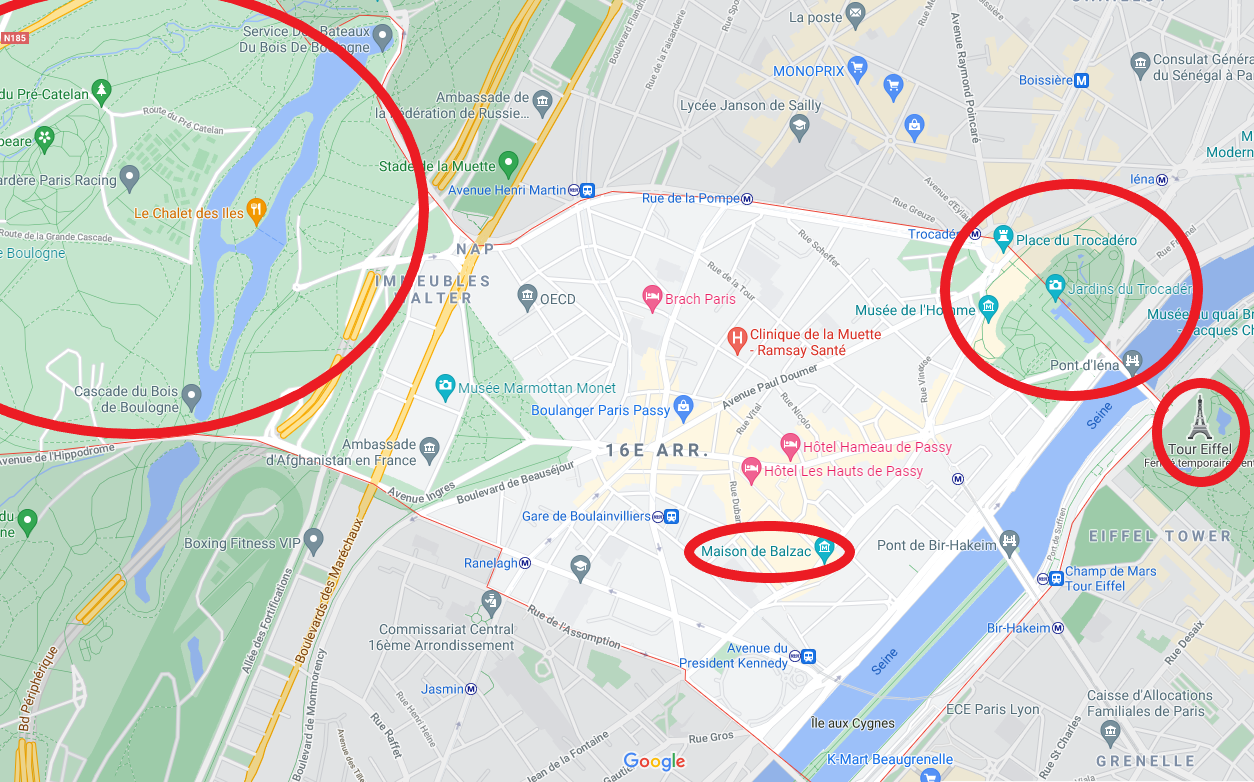

## Conclusion

The purpose of this project was to give us an idea of neighborhoods where it can be interested to start a new business of bubble tea. We tried to avoid places where the competition is already strong and where the market target is not expected to go. 

As we had still to deal with about 20 neighborhoods, we tried to determine which neighborhood is the most attractive by looking at parks, gardens, shopping points and monuments. 

This analysis should only be used as a starting point as several parameters such as the availability and the price of the real-estate or social and economic dynamics should be taken into consideration before taking a final decision.